### High-resolution Interpolation

In [355]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy
from mpmath import *

mp.dps = 256
eps = 1e-64

In [331]:
mp.matrix(4).rows

4

In [356]:
mp.pretty = True

class IPRInterpolation:
    def __init__(self, N, lam, load_from_disk = False):
        self.N   = N 
        self.lam = lam 
        self.x   = mp.linspace(-1, 1, N+1)[:-1]

        self.Winv = self.computeWInv(self.x, N)
        self.P    = self.computeInterpolationMatrix(N) 

        for i in range(self.Winv.rows):
            for j in range(self.Winv.cols):
                self.Winv[i, j] = chop(self.Winv[i, j], 1e-32)
        print(self.Winv)
        self.int  = self.P * self.Winv

        directory = "interpolation/"
        self.np_Winv = np.array(self.Winv.tolist(), dtype=complex)
        self.np_Winv.tofile(directory + f"WInv_N={N}_lambda={lam}.bin")

        self.np_P    = np.array(self.P.tolist(), dtype=float)
        self.np_P.tofile(directory + f"Polynomial_N={N}_lambda={lam}.bin")

        self.np_int  = np.array(self.int.tolist(), dtype=complex)
        self.np_int.tofile(directory + f"Interpolant_N={N}_lambda={lam}.bin")

    def polynomial(self, l, lam, x): 
        return mp.gegenbauer(l, lam, x, zeroprec=1000)

    #Construct matrices T and V recursively for arbitrary lambda
    def computeWInv(self, x, N): 
        # Even 
        W   = mp.matrix(N, N)
        pol = mp.matrix(N) 
        
        for l in range(N):
            # evaluate Gegenbauer polynomials
            for j in range(N): 
                pol[j, 1] = self.polynomial(l, self.lam, x[j])

            #compute DFT 
            pol = self.dft(pol)

            #write to W 
            for j in range(N): 
                W[j, l] = pol[j, 1]

        #return self.invertMatrix(W, 1e-10)
        return mp.inverse(W) 
    
    def dft(self, x):
        N = len(x)
        
        M = mp.matrix(N, N)
        for i in range(N):
            for j in range(N): 
                M[i, j] = mp.exp(-2j * mp.pi * i * j / N)
        return M * x
    
    def invertMatrix(self, M, cutoff):
        U, s, Vh = mp.svd(M)
        sinv = mp.diag(s) 

        plt.title("Singular values of W")
        plt.yscale("log")
        plt.plot(np.abs(s))
        plt.show() 

        print(np.abs(s))

        r = M.cols
        if M.rows < M.cols:
            r = M.rows
        for i in range(r):
            if s[i] < cutoff:
                sinv[i, i] = 0
            else:
                sinv[i, i] = 1/s[i]

        Vht = Vh.transpose_conj()
        Ut  = U.transpose_conj()
        f1  = sinv * Ut
        f2  = Vht * f1 
        return  f2
    
    def computeInterpolationMatrix(self, N):
        x = self.getInterpolationGrid(N) 
        P = mp.matrix(2*N, N) 
        for i in range(2*N):
            for j in range(N): 
                P[i, j] = self.polynomial(j, self.lam, x[i])
        return P
    
    def getGrid(self, N):
        return mp.matrix(mp.linspace(-1, 1,   N+1)[:-1])
    
    def getInterpolationGrid(self, N):
        return mp.matrix(mp.linspace(-1, 1, 2*N+1)[:-1]) + mp.mpf(1) / mp.mpf(2*N)
    
    def interpolate(self, fhat):
        frec   = np.matrix(self.int.tolist(), dtype=complex) @ fhat 
        return np.squeeze(np.asarray(frec.flatten()))
    

In [353]:
N = 10 
x   = np.linspace(-1, 1,   N + 1)[:-1]
xhr = np.linspace(-1, 1, 2*N+ 1)[:-1] + 1 / (2*N)
x, xhr

(array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 array([-0.95, -0.85, -0.75, -0.65, -0.55, -0.45, -0.35, -0.25, -0.15,
        -0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,  0.75,
         0.85,  0.95]))

In [357]:

inter = IPRInterpolation(64, 0.5)

[0.01562499999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999995709942319681586                                                                                                                                                                                                                                                                                                         0.0                                                                                                                                                                                                                                                                                                       0.0                                                                                                                                              

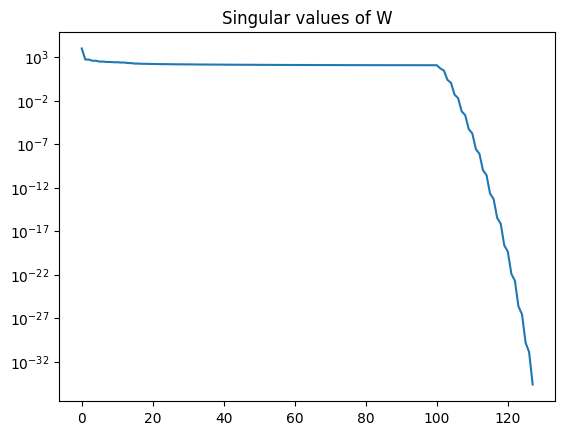

[9514.835219111227709820863746334722617845741436179470008935036293583235876482544175545317151272798035751528010082826046517428920990239266001130431154291952248142426343779178658263539818695190211331438050599142945193307862411788339855074805568265838937776669
 510.488771595835310591680069903770854521940657159071211658111359188836872256704632145569615424759142000373910003285385175382304157218741492639633587711000190516030643510291375593168212586432139473076133402567285798554250316746560477737858498781035233125018
 507.7881095826039895303972086028035764536590106790346117702888158023274581989121383639944787184061122453266950624473082172350111123802396138258796594028823918386211513564649180589164174729559142526435866151662032615400985898079207159359340136175261276241792
 369.470815097313021646290887405755867242659279411687665896043492130439614287003716300351158565706572824692011878301225677147937988927114383976799288897248095305725211678948071473328037683730961582253913657591800097014913666

In [325]:

inter = IPRInterpolation(128, 1)

In [318]:
for lam in [mp.mpf(0.5)]: 
    for N in range(32, 33): 
        print("Lambda = ", lam, " N = ", N)
        inter = IPRInterpolation(N, lam)
        #x     = np.array(inter.getGrid(N).tolist(), dtype=float)
        #xhr   = np.array(inter.getInterpolationGrid(N).tolist(), dtype=float)
#
        x   = np.linspace(-1, 1,   N + 1)[:-1]
        xhr = np.linspace(-1, 1, 2*N+ 1)[:-1] + 1 / (2*N)
#
        def f(x):
            return np.sin(20*x)
        fhat = scipy.fft.fft((f(x)))
#
        frec  = inter.interpolate(fhat) 
#
        plt.title(f"New interpolation: {np.mean(np.abs(frec - np.real(f(xhr)))[1:-3]):5.5e}")
        plt.plot(x, f(x), label="f") 
        plt.plot(xhr[1:-3], frec[1:-3], label="frec")
        plt.legend()
        plt.show()

Lambda =  0.5  N =  32


KeyboardInterrupt: 

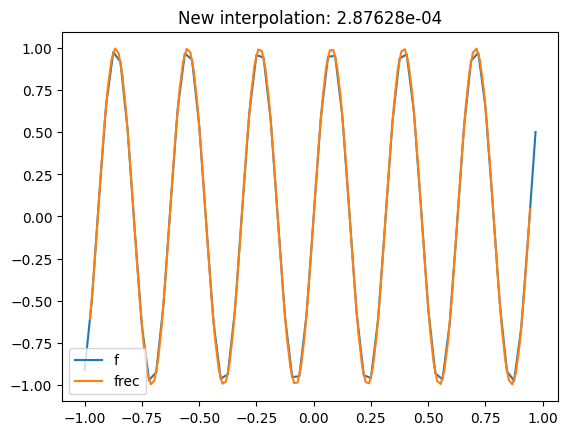

In [295]:

x   = np.linspace(-1, 1,   N + 1)[:-1]
xhr = np.linspace(-1, 1, 2*N+ 1)[:-1] + 1 / (2*N)
#
def f(x):
    return np.sin(20*x)
fhat = scipy.fft.fft((f(x)))
#
frec  = inter.interpolate(fhat) 
#
plt.title(f"New interpolation: {np.mean(np.abs(frec - np.real(f(xhr)))[1:-3]):5.5e}")
plt.plot(x, f(x), label="f") 
plt.plot(xhr[1:-3], frec[1:-3], label="frec")
plt.legend()
plt.show()

In [ ]:
for N in range(50, 128, 1): 
    inter = IPRInterpolation(N, mp.mpf(0.5))
    x     = np.array(inter.getGrid(N).tolist(), dtype=float)
    xhr   = np.array(inter.getInterpolationGrid(N).tolist(), dtype=float)

    x   = np.linspace(-1, 1,   N + 1)[:-1]
    xhr = np.linspace(-1, 1, 2*N+ 1)[:-1] + 1 / (2*N)

    def f(x):
        return x
    fhat = scipy.fft.fft((f(x)))

    print(fhat)
    frec  = inter.interpolate(fhat) 

    plt.title(f"New interpolation: {np.mean(np.abs(frec - np.real(f(xhr)))):5.5e}")
    plt.plot(x, f(x), label="f") 
    plt.plot(xhr, frec, label="frec")
    plt.legend()
    plt.show()

In [289]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy
import sys

orig_stdout = sys.stdout
f = open('IPRInterpolationTables.h', 'w')
sys.stdout = f



def printCMatrix(mat, name):
    n, m = mat.shape    

    print(f"const static gamer_float_complex  {name}[{n}][{m}] = ", end="")
    print("{")
    for i in range(n):
        print("{", end="")
        for j in range(m):
            print(f"{np.real(mat[i,j]):10.64f}, {np.imag(mat[i,j]):10.64f}", end="")
            if j != m - 1:
                print(", ", end="")
        

        print("}", end=",\n")  
    print("}", end=";\n")  

print(
r"""
# ifndef __IPR_INTERPOLATION_TABLES_H__
# define __IPR_INTERPOLATION_TABLES_H__

# include "CUFLU.h"
# include "Macro.h"


// **********************************************************************************************************
// ** Precomputed IPR (Inverse Polynomial Reconstruction) interpolation tables                             **
// ** N             = 2-60                                                                                 **
// ** LAMBDA        = 0.5                                                                                  **
// **********************************************************************************************************""")

print("")

lam = 0.5

first = 1

Ns     = np.arange(2, 10)
totalN = len(Ns)
for N in range(2, 10):


    table = np.fromfile(f"interpolation/Interpolant_N={N}_lambda={lam}.bin", dtype=complex).reshape(2 * N, N) 


    printCMatrix(table, f"IPR_N{N}")
    print("")


print(
r"""
static const ipr_float* IPR_Tables[""", end="")
print(totalN, end="")
print(
r"""] = {""")

for N in range(2, 10):

    print(f"&IPR_N{N}[0][0], ", end="")
    
print(
r"""
};

# endif // # ifndef __IPR_INTERPOLATION_TABLES_H__""")


sys.stdout = orig_stdout
f.close()